In [1]:
# declaring all dependancies    
import qutip as qt
import numpy as np
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
from quantum_logical.pulsesim.build_hamiltonian import Build_hamiltonian
import matplotlib.pyplot as plt
from qutip import Options
from tqdm import tqdm_notebook as tqdm
from progressbar import progressbar

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None


c:\Users\girgi\Desktop\Github\quantum_logical\venv\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [13]:
# adding all of the necessary elements to the full creation of the system 
qubit_dim = 3

# frequencies 
w1_un = 4
w2_un = 6
w3_un = 4.6666666666666666
ws_un = 5.6666666666666666

# coupling strength coefficient 
g1s = 2 * np.pi * 0.05467
g2s = 2 * np.pi * 0.0435
g3s = 2 * np.pi * 0.04875

# create array of the coefficients should be useful 
gs = [g1s, g2s, g3s]

# unknown value as of now 
g3 = .1

In [14]:
# creating the qubits and the hilbert space
qubit1 = QubitMode(
    mode_type="Qubit", name="q1", dim=qubit_dim, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    mode_type="Qubit", name="q2", dim=qubit_dim, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    mode_type="Qubit", name="q3", dim=qubit_dim, freq=w3_un, alpha=-0.160, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(mode_type="Snail", name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    frozenset([qubit3, snail]): 2 * np.pi * 0.04875
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

system = []
system.extend(qubits)
system.extend([snail])


In [15]:
# list of qubit coupling strengths that will be given
g13 = g23 = g12 = .01
gqs = [[qubit1.freq / (2 * np.pi),g12,g13],[g12,qubit2.freq / (2 * np.pi),g23],[g13,g23,qubit3.freq / (2 * np.pi)]]

# creating the list of alphas that will be given to us 
a1 = a2 = a3 = .1
alphas = [a1, a2, a3]

In [16]:
# building the hammiltonian up to the pump term 
# creating the linear parts of the hamiltonian  
# the qubit and snail separate terms
H_no_interaction = [(i.freq / (2 * np.pi)) * (qs.modes_a_dag[i] * qs.modes_a[i]) for i in system]

# creating the snail mixing with the qubits terms
H_snail_qubits = [gs[qubits.index(i)] * (qs.modes_field[snail] * qs.modes_field[i]) for i in qubits]

# adding the coupling terms between the qubits 
H_qubit_qubit = []

for i in range(len(qubits)):
    for j in range(len(qubits)):
        if j > i:
            H_qubit_qubit.append(gqs[i][j] * (qs.modes_field[qubits[i]] * qs.modes_field[qubits[j]]))

# creating the nonlinear parts of the hamiltonian 
# adding the snail third order term first 
H_snail_third = [g3 * ((qs.modes_field[snail]) ** 3)]

# add the qubit non-linearity 
H_qubit_fourth = [alphas[qubits.index(i)] * ((qs.modes_field[i]) ** 4) for i in qubits]


In [17]:
# creating the non-linear parts of the hamiltonian 

H_total_no_time = []
# adding the linear parts into the hamiltonian 
H_total_no_time.extend(H_no_interaction)
H_total_no_time.extend(H_snail_qubits)
H_total_no_time.extend(H_qubit_qubit)
# adding the non-linear parts 
H_total_no_time.extend(H_snail_third)
H_total_no_time.extend(H_qubit_fourth)


In [18]:
H_no_time = sum(H_total_no_time)

In [19]:
# adding the time dependent terms 
# this might have to be done with a constant pulse first but it should be easy to implement the more complex ones 

H_time = (qs.modes_field[snail])

# making a pulse for the function 
def w_t(a, b, t):
    return a * np.sin(b * t)

amp = 2.1052631578947367
freq = 0.6578947368421052 
def wt(t, args = None):
    return w_t(amp, freq, t)

H = [H_no_time,[H_time, wt]]



In [20]:
# create the intial state 
psi0 = qt.tensor(qt.basis(qubit_dim,1), qt.basis(qubit_dim,0), qt.basis(qubit_dim,0), qt.basis(snail.dim))
# have to find the eigenstates of the hamiltonian in order to find the most fitting starting state
rho0 = psi0 * psi0.dag()

In [21]:
# # finding the eigenstates of the hamiltonian before the pulse acts on it and that is the prepared state 
# eigenvalues, eigenvectors = H_no_time.eigenstates()

# a = []
# for i in eigenvectors:
#     a.append(np.abs(psi0.dag() * i))

# max(a)

# # this is now my initial state that is based on the eigenstates of the hamiltonian 
# psi0 = eigenvectors[a.index(max(a))]  



In [22]:
# run mesolve over the hamiltonian 
tlist = np.linspace(0,1000,100)
result = qt.mesolve(H = H, rho0 = psi0, tlist = tlist, options= opts, progress_bar=True)

c:\Users\girgi\Desktop\Github\quantum_logical\venv\lib\site-packages\qutip\solver\solver_base.py:434: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


10.1%. Run time:   0.48s. Est. time left: 00:00:00:04
20.2%. Run time:   0.97s. Est. time left: 00:00:00:03
30.3%. Run time:   1.45s. Est. time left: 00:00:00:03
40.4%. Run time:   1.92s. Est. time left: 00:00:00:02
50.5%. Run time:   2.41s. Est. time left: 00:00:00:02
60.6%. Run time:   2.88s. Est. time left: 00:00:00:01
70.7%. Run time:   3.36s. Est. time left: 00:00:00:01
80.8%. Run time:   3.85s. Est. time left: 00:00:00:00
90.9%. Run time:   4.33s. Est. time left: 00:00:00:00
100.0%. Run time:   4.76s. Est. time left: 00:00:00:00
Total run time:   4.76s


In [23]:
# # before comparing put the states in the eigenstate of the hamiltonian 
# # this does not make any sense at all 
# for j in range(len(result.states)):
#     a = []
#     for i in range(len(eigenvectors)):
#         a.append(np.abs(result.states[j].dag() * eigenvectors[i]))

#     result.states[j] = result.states[a.index(max(a))]


C:\Users\girgi\AppData\Local\Temp\ipykernel_9264\718146446.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


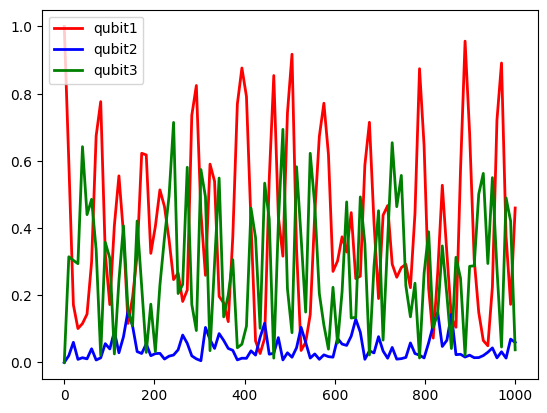

In [25]:
fig, ax = plt.subplots()
ax.plot(tlist, np.abs(qt.expect(qs.modes_a_dag[qubit1]*qs.modes_a[qubit1], result.states)), 'r', linewidth = 2, label = "qubit1")
ax.plot(tlist, np.abs(qt.expect(qs.modes_a_dag[qubit2]*qs.modes_a[qubit2], result.states)), 'b', linewidth = 2, label = "qubit2")
ax.plot(tlist, np.abs(qt.expect(qs.modes_a_dag[qubit3]*qs.modes_a[qubit3], result.states)), 'g', linewidth = 2, label = "qubit3")
# ax.plot(tlist, np.abs(qt.expect(qs.modes_a_dag[snail]*qs.modes_a[snail], result.states)), 'y', linewidth = 2, label = "snail")
ax.legend()
fig.show()

In [14]:
num = []
for i in result.states:
    num.append(np.abs(qt.expect(qs.modes_a_dag[qubit1]*qs.modes_a[qubit1], i)) + np.abs(qt.expect(qs.modes_a_dag[qubit2]*qs.modes_a[qubit2], i)) 
    + np.abs(qt.expect(qs.modes_a_dag[qubit3]*qs.modes_a[qubit3], i)))

num

[1.0,
 0.9878219070800845,
 0.9680151234597962,
 0.8668173690131513,
 0.9230059756819776,
 0.8118863841731225,
 0.9483720367192385,
 0.9886774542032417,
 0.9758751263362869,
 0.9424833794316211,
 0.9913089201652985,
 0.9934426949987493,
 0.9372470194233463,
 0.949541775962435,
 1.0083530354951629,
 0.8860758543377245,
 0.8528063508839022,
 0.9299177805039921,
 0.671227806952309,
 0.821927149594066,
 0.8978329466536223,
 0.8118640072803707,
 0.8333751465580808,
 0.7975610898598574,
 0.7513021211124457,
 0.8232793711114486,
 0.8884663810108355,
 0.8812520544799407,
 0.9875999583344117,
 0.8861740753587399,
 0.9106610428583426,
 1.00376521370914,
 0.9182460512145936,
 0.9419659151947752,
 0.9998321602406078,
 0.8463999759155406,
 0.924813315831205,
 0.8236448878263823,
 0.7270266965583427,
 0.9308981724927472,
 0.8352041876717918,
 0.8945644746265646,
 0.9162673386158352,
 0.8244722031075921,
 0.8030319176937528,
 0.9713974444190724,
 0.9226589833140354,
 0.9562144568465103,
 1.0055433733

In [15]:
# creating the expected final state 
psif = qt.tensor(qt.basis(qubit_dim,0), qt.basis(qubit_dim,0), qt.basis(qubit_dim,1), qt.basis(snail.dim))
rhof = psif * psif.dag()

# tracing out the bad parts since the snail may still be excited 
psif = qt.ptrace(psif,[0,1,2])

In [16]:
final_state = qt.ptrace(result.states[-1], [0,1,2])
qt.fidelity(psif, final_state)

0.9521798071256106

In [17]:
# will optimize over the amplitude of the pulse and maybe frequency 
# creating the tuple of amps and frequencies 
amps = np.linspace(0, 4, 20)
freqs = np.linspace(0, 2.5, 20)
amps_freqs = [(i,j) for i in amps for j in freqs]

def sim_task(amps_freqs):
    amp, freq = amps_freqs

    def w_t(a, b, t):
        return a * np.sin(b * t)

    def wt(t, args = None):
        return w_t(amp, freq, t)
    
    H_pump = [H_time, wt]

    H_t = [H_no_time, H_pump]

    res = qt.mesolve(H = H_t, rho0 = psi0, tlist = tlist, options= opts)

    # add the fid calculation
    fid = qt.fidelity(qt.ptrace(res.states[-1], [0,1,2]), psif)

    return amp, freq, fid


results = qt.parallel.parallel_map(task = sim_task, values = amps_freqs, progress_bar= True)


Total run time:   0.47s


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.